# Projection of political actors onto distributive and value-based ideological axes

In [28]:
# Make sure politician2vec is up to date
#%pip uninstall politician2vec -y
#%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
# import multiprocessing
# available_workers = multiprocessing.cpu_count()
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

In [30]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs.p'

parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP', 'M', 'DD', 'UFG', 'KD']")
parl_data.shape

(89729, 7)

In [31]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])


In [33]:
# Load embedding
model_path = 'embedding_models/fastlearn_v2_new_preproc_parties_cut.txt'
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [23]:
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'Konservative',
   6: 'SF',
   7: 'Liberal_Alliance',
   #8: 'UFG',
   9: 'Alternativet',
   10: 'Danmarksdemokraterne',
   11: 'Nye Borgerlige',
   12: 'Frie Grønne',
   #13: 'Moderaterne',
   #14: 'Kristendemokraterne'
}

In [24]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME!!!!!
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    #'KD': '#566197',
    'FG': '#E4F04E',
    #'DD': '#3470BC',
    #'M': '#7A308B',
    #'SIU': 'lightgrey',
    #'UFG': 'lightgrey'
}

In [36]:
grouped_docs['party'].value_counts()

S      51
V      43
DF     34
EL     16
RV     15
SF     15
KF     14
LA     13
ALT    11
NB      4
FG      3
Name: party, dtype: int64

In [37]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 10,
    snippets = True
)

party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())

party_labels = party_df.drop_duplicates(keep = 'first', subset = 'party').sort_values(by='rank', ascending=False)

partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

party_labels

party sizes before filtering (party 10 is "Other"):

[[ 0 49]
 [ 1 42]
 [ 2 36]
 [ 3 17]
 [ 4 15]
 [ 5 14]
 [ 6 14]
 [ 7 14]
 [ 8 11]
 [ 9  4]
 [10  4]]


ValueError: Length of values (219) does not match length of index (216)

In [ ]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')
combined_hover

,doc,party,snippet,color,full_name,rank
0,0.0,DF,tak det åbne spørgsmål er jo hvad socialdemokr...,#265BA4,Alex Ahrendtsen,34.0
1,1.0,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13.0
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,51.0
3,3.0,LA,tak for det og tak for en saglig og konstrukti...,#E7B657,Anders Samuelsen,13.0
4,4.0,RV,i radikale venstre forstår vi lovforslaget såd...,#D82E8A,Andreas Steenberg,15.0
...,...,...,...,...,...,...
227,NaN,LA,NaN,black,NaN,NaN
228,NaN,ALT,NaN,black,NaN,NaN
229,NaN,NB,NaN,black,NaN,NaN
230,NaN,FG,NaN,black,NaN,NaN


In [61]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [62]:
from itertools import combinations
from tqdm.notebook import tqdm

class Subdimension:
    def __init__(self, present_words, absent_words):
        self.words = {'present': present_words, 'absent': absent_words}
        self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
    
    def add_words(self, words, present = True):
        '''
        Manually add extra words and their vector representations to the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._add_word(word, present)
    
    def remove_words(self, words, present = True):
        '''
        Manually remove words and their vector representations from the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._remove_word(word, present)

    # Backend/helper functions below
    def _add_word(self, word, present = True): # TODO: Make it impossible to add the same word twice...
        self.words['present' if present else 'absent'].append(word)
        self.vecs['present' if present else 'absent'].append(self.get_vec(word))

    def _remove_word(self, word, present = True):
        remove_idx = self.words['present' if present else 'absent'].index(word)
        self.words['present' if present else 'absent'].remove(word)
        del self.vecs['present' if present else 'absent'][remove_idx]

    def calc_subdim_vecs(self):
        '''
        Return the arithmetic mean of both the "present" and the "absent"
        word sets (i.e. construct the endpoints of the subdimension).
        '''
        return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent'])
    
    def optimise_subdim(self, present=True, min_size=2, max_size=None, replace=True):
        '''
        Optimise the subdimension by finding the word set that maximises the average cosine similarity

        Parameters
        ----------
        present : bool, optional
            Whether to optimise the "present" or "absent" endpoint of the subdimension, by default True
        min_size : int, optional
            Minimum number of words in the word set, by default 2
        max_size : int, optional
            Maximum number of words in the word set, by default None (i.e. no limit)
        replace : bool, optional
            Whether to replace the original word set with the optimised one, by default True

        Returns
        -------
        best_group : list
            The optimised word set.
        best_labels : list
            The corresponding word labels.
        best_sim : float
            The average cosine similarity of the optimal word set.
        '''
        
        best_group, best_labels, best_sim = self.optimise_group_similarity(
            vectors=self.vecs['present' if present else 'absent'],
            labels=self.words['present' if present else 'absent'],
            min_size=min_size,
            max_size=max_size
            )
        
        if replace:
            self.words['present' if present else 'absent'] = best_labels
            self.vecs['present' if present else 'absent'] = best_group
        
        print('Best avg. cosine similarity:', best_sim)
        
        return best_group, best_labels
    
    @staticmethod
    def get_vec(word):
        '''Retrieve the vector representation of a given word from the politician2vec model.'''
        idx = pol2vec_model.word_indexes[word]
        vec = pol2vec_model.word_vectors[idx]

        return vec
    
    @staticmethod
    def mean_vec(vecs):
        return np.mean(vecs, axis=1)

    @staticmethod
    def group_cosine_similarity(vectors):
        '''
        Calculates the average cosine similarity between all pairs of vectors in a group.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.

        Returns
        -------
        float: The average cosine similarity between all pairs of vectors in the group.
       '''

        # calculate the pairwise cosine similarities
        pairwise_sims = []
        for v1, v2 in combinations(vectors, 2):
            sim = calc_cos_sim(v1,v2)
            pairwise_sims.append(sim)

        # calculate the average cosine similarity
        avg_sim = np.mean(pairwise_sims)

        return avg_sim

    def optimise_group_similarity(self, vectors, labels, min_size, max_size):
        '''
        Optimizes the average cosine similarity of a group of vectors byiteratively removing and
        including different combinations.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.
        labels (list): A list of labels for the vectors.
        min_size (int): The minimum size of the group to consider. Default is 2.
        max_size (int): The maximum size of the group to consider. Default is None (use all vectors).

        Returns
        -------
        list: The optimized group of vectors that maximizes the average cosine similarity.
        list: The labels of the vectors in the optimized group.
        float: The maximum average cosine similarity achieved by the optimized group.
        '''

        # set max_size to len(vectors) if not specified
        if max_size is None:
            max_size = len(vectors)

        # initialize the best group, labels, and similarity
        best_group = None
        best_labels = None
        best_sim = 0.0

        # iterate over all possible group sizes
        for size in tqdm(range(min_size, max_size+1)):
            
            # iterate over all possible combinations of vectors
            for group_idx in combinations(range(len(vectors)), size):
                
                # get the vectors and labels for the current group
                group = [vectors[i] for i in group_idx]
                group_labels = [labels[i] for i in group_idx]
                
                # calculate the average cosine similarity of the group
                sim = self.group_cosine_similarity(group)
                
                # update the best group, labels, and similarity if a new maximum is found
                if sim > best_sim:
                    best_group = group
                    best_labels = group_labels
                    best_sim = sim

        return best_group, best_labels, round(best_sim, ndigits=3)


In [63]:
# TODO: FIX PARTY INDECES!!!!!!! THIS IS WHY EL SEEMS TO BE POSITIONED INCORRECTLY........
# TODO: Try projecting both parties and politicians
# TODO: Stick to the planned keyword expansion procedure!
# TODO: Deterministic optimisation procedure or not???
# TODO: Include exploration of n-gramsin keyword expansion functionality

distrib_left_words = [
    'bør beskattes',
    'arbejdere',
    'bekæmpe ulighed',
    'skattelettelser rigeste',
    'ramt kontanthjælpsloftet',
    # 'velfærdsydelser',
    # 'højere skat',
    # 'økonomisk ulighed',
    # 'økonomiske vilkår',
    'dårligst stillede',
    # 'svageste',
    # 'bedre velfærd',
    'bekæmpe skattely',
    # 'skæve skattelettelser',
    # 'socialt sikkerhedsnet',
    # 'ulighedsskabende',
    'multinationale selskaber',
    # 'vores velfærdssektor',
    # 'rigeste',
    # 'profit',
    # 'fattigste',
    # 'mindsteløn',
    'løn arbejdsvilkår',
    # 'offentlige arbejdspladser',
    # 'kontanthjælpsloftet'
    ]

distrib_right_words = [
    # 'betaler topskat',
    'bruger skatteborgernes',
    'fjerne selskabsskatten',
    'lette topskatten',
    'passiv overførselsindkomst',
    'konkurrence',
    # 'gøres billigere',
    # 'sænke topskatten',
    # 'selskabsskatten',
    # 'højeste skattetryk',
    # 'største offentlige',
    'dansk erhvervsliv',
    'offentlige udgifter',
    # 'virksomheder',
    # 'økonomisk vækst',
    # 'udgifter',
    # 'erhvervsdrivende',
    # 'beskatning',
    'lavere arveafgift',
    # 'privatisering',
    'registreringsafgiften'
    ]

value_left_words = [
    'ligestilling mangfoldighed',
    'racisme diskrimination',
    'klima miljø',
    #'automatisk statsborgerskab',
    'religionsfrihed',
    'udhuler udviklingsbistanden',
    # 'flygtninge',
    # 'ligeløn',
    # 'diversitet',
    'homoseksuelles rettigheder',
    # 'bæredygtig udvikling',
    # 'biodiversitet',
    'skader integrationen',
    # 'klima',
    # 'diskrimination',
    # 'mangfoldighed',
    # 'grøn omstilling',
    'bæredygtighed',
    # 'ligestilling',
    # 'udrejsecentre',
    # 'miljø',
    'opnå indfødsret',
    # 'fællesskab',
    # 'racisme',
    # 'flygtninge'
    ]

value_right_words = [
    'frihed ansvar',
    'danske værdier',
    # 'staten blander',
    'trusler ytringsfriheden',
    'stram udlændingepolitik',
    # 'migranter',
    'kultur tradition',
    'kriminelle udlændinge',
    # 'modtagecenter tredjeland',
    # 'islamisk tørklæde',
    # 'islamister',
    'afbureaukratisering',
    # 'frihedsrettigheder',
    # 'personlig frihed',
    'selvbestemmelse',
    # 'lokalsamfund',
    'bør udvises',
    'islamisering danmark',
    'lokalsamfundet',
    # 'individet',
    'strengere straffe'
    ]

In [64]:
pol2vec_model.model.wv.most_similar(positive = ['omfordeling'], topn = 25)

[('fordelt', 0.3358210325241089),
 ('målretter', 0.32401376962661743),
 ('indkomster', 0.3186330497264862),
 ('forældreindkomst', 0.31216374039649963),
 ('fordeler', 0.30778637528419495),
 ('topskattegrænsen', 0.3004043698310852),
 ('overførselsindkomst', 0.2983665466308594),
 ('omfordele', 0.2973327040672302),
 ('lavet', 0.2930494546890259),
 ('afgiftslettelser', 0.2929106056690216),
 ('klumper', 0.2918870151042938),
 ('retfærdig', 0.28782570362091064),
 ('serviceniveau', 0.28704172372817993),
 ('beskæftigelsesfradraget', 0.28644999861717224),
 ('velfærdsstat', 0.2859804928302765),
 ('socialt', 0.2842405438423157),
 ('rigeste', 0.27594828605651855),
 ('selskabsskatten', 0.27593696117401123),
 ('mia', 0.2744261622428894),
 ('penge', 0.27336636185646057),
 ('lavede', 0.27297264337539673),
 ('spare', 0.2724546194076538),
 ('velfærdssamfund', 0.26912611722946167),
 ('skattelettelser', 0.2672564387321472),
 ('geografisk', 0.26603126525878906)]

In [65]:
distrib_dimension = Subdimension(
    present_words=distrib_left_words,
    absent_words=distrib_right_words
    )

value_dimension = Subdimension(
    present_words=value_left_words,
    absent_words=value_right_words
    )

In [66]:
print(distrib_dimension.words)
print(len(distrib_dimension.vecs['present']))

{'present': ['bør beskattes', 'arbejdere', 'bekæmpe ulighed', 'skattelettelser rigeste', 'ramt kontanthjælpsloftet', 'dårligst stillede', 'bekæmpe skattely', 'multinationale selskaber', 'løn arbejdsvilkår'], 'absent': ['bruger skatteborgernes', 'fjerne selskabsskatten', 'lette topskatten', 'passiv overførselsindkomst', 'konkurrence', 'dansk erhvervsliv', 'offentlige udgifter', 'lavere arveafgift', 'registreringsafgiften']}
9


In [67]:
# Present:
for subdimension in [distrib_dimension, value_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=True, min_size=8, max_size=8, replace=True)
    print(best_words)

# Absent:
for subdimension in [distrib_dimension, value_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=False, min_size=8, max_size=8, replace=True)
    print(best_words)

  0%|          | 0/1 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.537
['bør beskattes', 'bekæmpe ulighed', 'skattelettelser rigeste', 'ramt kontanthjælpsloftet', 'dårligst stillede', 'bekæmpe skattely', 'multinationale selskaber', 'løn arbejdsvilkår']


  0%|          | 0/1 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.454
['ligestilling mangfoldighed', 'racisme diskrimination', 'klima miljø', 'religionsfrihed', 'udhuler udviklingsbistanden', 'homoseksuelles rettigheder', 'skader integrationen', 'opnå indfødsret']


  0%|          | 0/1 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.496
['bruger skatteborgernes', 'fjerne selskabsskatten', 'lette topskatten', 'passiv overførselsindkomst', 'konkurrence', 'dansk erhvervsliv', 'offentlige udgifter', 'lavere arveafgift']


  0%|          | 0/1 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.581
['frihed ansvar', 'danske værdier', 'trusler ytringsfriheden', 'stram udlændingepolitik', 'kriminelle udlændinge', 'bør udvises', 'islamisering danmark', 'strengere straffe']


In [68]:
distrib_left, distrib_right = distrib_dimension.calc_subdim_vecs()
value_left, value_right = value_dimension.calc_subdim_vecs()


distrib_axis = distrib_right - distrib_left
value_axis = value_left - value_right

In [69]:
# assume we have a matrix of word and document vectors called `embedding_matrix`
# with shape (num_documents, embedding_dimension)
embedding_matrix = pol2vec_model.party_vectors

# assume we have three subdimension vectors called `v1`, `v2`, and `v3`
# with shape (embedding_dimension,)

# create a matrix called `projection_matrix` with shape (embedding_dimension, 3)
# that has the three subdimension vectors as columns
projection_matrix = np.stack((distrib_axis, value_axis), axis=1)

# project the document vectors onto the subspace described by the three
# subdimension vectors by multiplying the embedding matrix by the projection
# matrix 
# the resulting matrix will have shape (num_documents, 3)
projected_matrix = embedding_matrix.dot(projection_matrix)

# The resulting projected_matrix will be a matrix with shape (num_documents, 3)
# that represents the document vectors projected onto the subspace described by
# the three "special" vectors. Each row of the matrix corresponds to a document,
# and the three columns correspond to the three sub-dimensions of populism

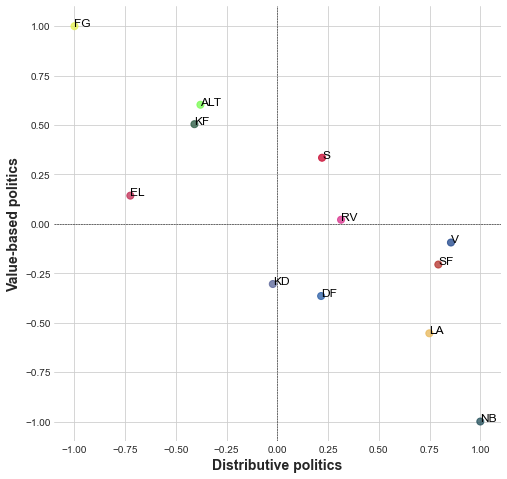

In [70]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
#from mpl_toolkits.mplot3d import Axes3D

# Assume you have a matrix of politician embeddings in the populism subspace,
# where each row represents an embedding and each column represents a subdimension.
embeddings = projected_matrix

normalised_emb = 2*(embeddings - np.min(embeddings, axis=0)) / np.ptp(embeddings, axis=0) - 1

# Initialize the plot and set the axis labels
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111) #, projection='3d'
ax.set_xlabel('Distributive politics', size = 14, weight = 'bold')
ax.set_ylabel('Value-based politics', size = 14, weight = 'bold')
#ax.set_zlabel('Moralised politics')

# Set the range of the axis
# ax.set_xlim([0.02, 0.125])
# ax.set_ylim([-0.01, 0.2])
# ax.set_zlim([0, 0.075])

# Create a scatter plot of the politician embeddings
xs = normalised_emb[:,0]
ys = normalised_emb[:,1]
#zs = embeddings[:,2]
pd.DataFrame(zip(xs, ys, party_labels['party']), columns=['V4_scale', 'value', 'party']).to_csv('data/plot_data_test.csv')

ax.scatter(xs, ys, s=50, alpha=0.75, color=party_labels['color']) #, zs

for i, embedding in enumerate(normalised_emb):
    x, y = embedding #, z
    ax.text(x, y, party_labels.iloc[i]['party'], color='black', size=12) #, z

# add vline to plot
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(y=-0, color='black', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Show the plot
plt.show()

<img src="ideological_compass.jpeg"  width="600">

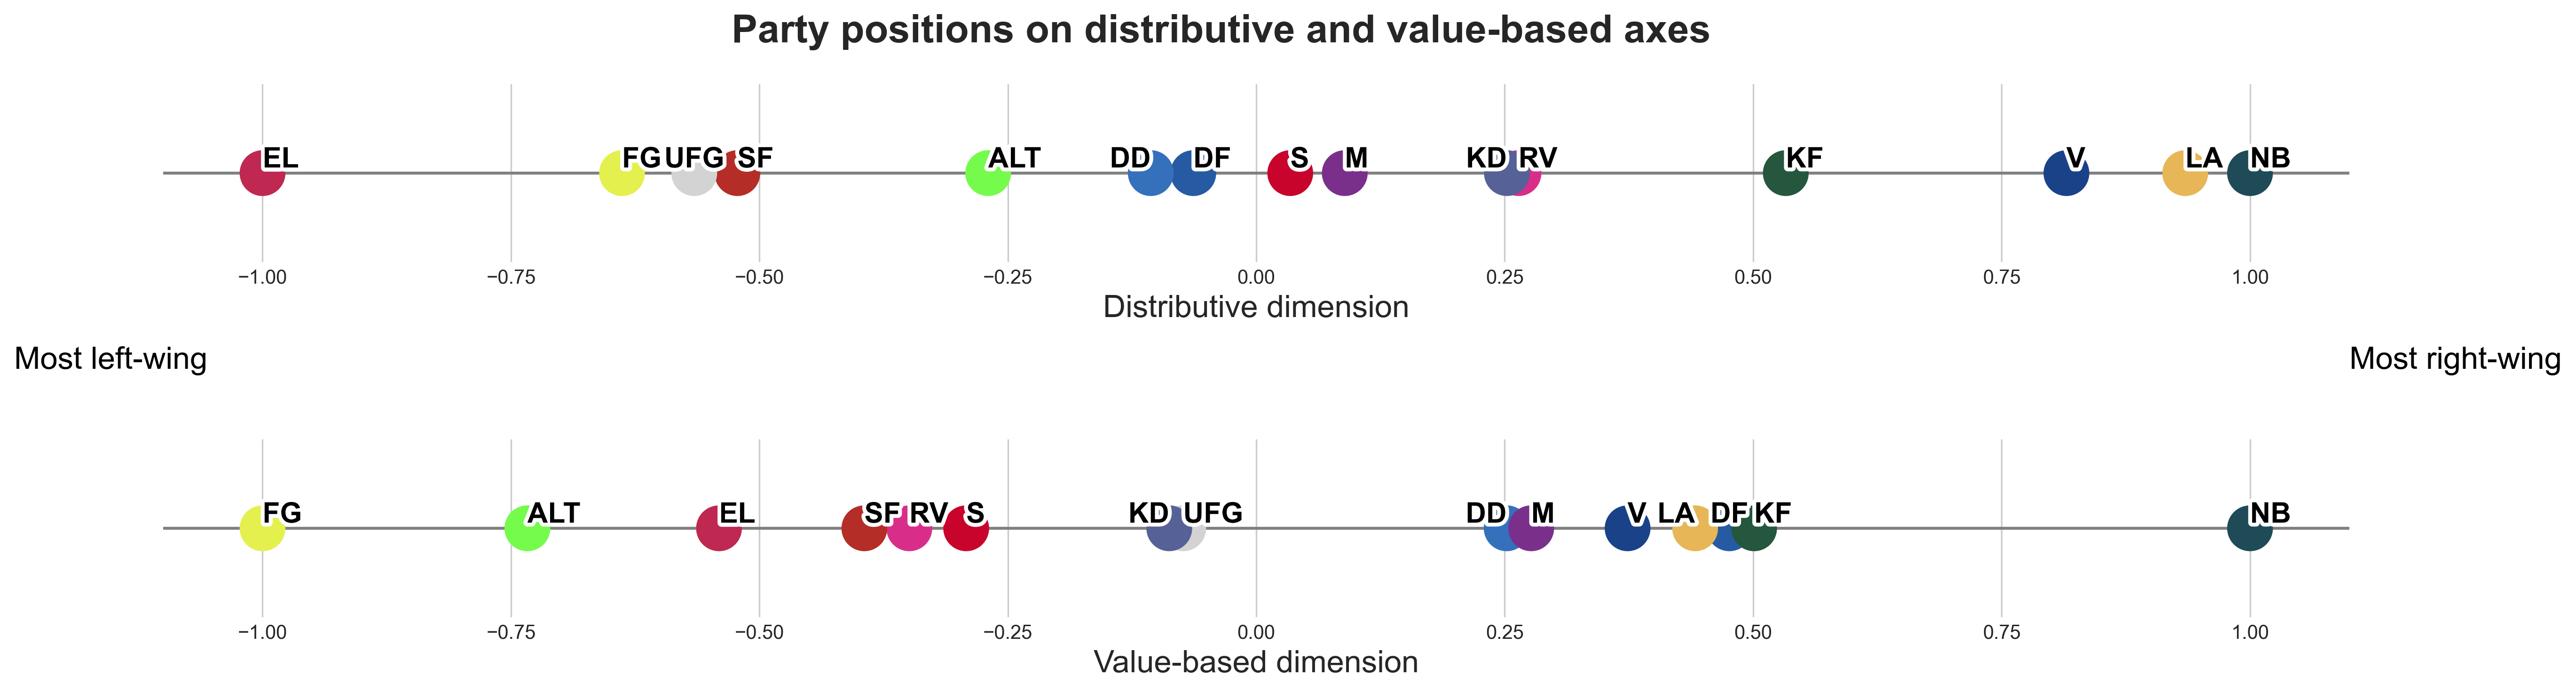

In [29]:
from adjustText import adjust_text
import matplotlib.patheffects as pe
colorlist = combined_hover.dropna()['color']

# project politicians onto each subdimension
proj_dim1 = np.dot(pol2vec_model.party_vectors, distrib_axis)
proj_dim2 = np.dot(pol2vec_model.party_vectors, value_axis)

# rescale each dimension to be between -1 and 1
proj_dim1 = (proj_dim1 - proj_dim1.min()) / (proj_dim1.max() - proj_dim1.min()) * 2 - 1
proj_dim2 = (proj_dim2 - proj_dim2.min()) / (proj_dim2.max() - proj_dim2.min()) * 2 - 1

#flip second dim:
proj_dim2 = -proj_dim2

# create 3x1 subplot
fig, axs = plt.subplots(2, 1, figsize=(20, 5))

# add space between subplots
fig.subplots_adjust(hspace=1)

# add hline at 0, behind the scatterplot points
for ax in axs:
    ax.axhline(y=0, color='grey', linestyle='-', linewidth=1.5)

# plot projection onto first subdimension
axs[0].scatter(proj_dim1, np.zeros_like(proj_dim1), c=party_labels['color'], s = 500, zorder=2)
axs[0].set_xlabel('Distributive dimension', size = 16)
axs[0].set_ylim(-0.1, 0.1)

# plot projection onto second subdimension
axs[1].scatter(proj_dim2, np.zeros_like(proj_dim2), c=party_labels['color'], s = 500, zorder=2)
axs[1].set_xlabel('Value-based dimension', size = 16)
axs[1].set_ylim(-0.1, 0.1)

# add party labels to each of the subplots without adjusting text positions
for i, party in enumerate(party_labels['party']):
    axs[0].text(proj_dim1[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=4, foreground='white')])
    axs[1].text(proj_dim2[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=4, foreground='white')])

# adjust text positions to avoid overlapping
for ax in axs:
    adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.55, force_text=0.5, expand_points=(1,1), expand_text=(1,1))

for ax in axs:
    ax.set_yticklabels([])
    ax.grid(False, axis = 'y', which = 'both')
    
    for spine in ax.spines.values():
        spine.set_visible(False)

# add text note to each endpoint of each subplot
axs[0].text(1.1, -0.22, 'Most right-wing', size=16, color='black')
axs[0].text(-1.25, -0.22, 'Most left-wing', size=16, color='black')

plt.suptitle('Party positions on distributive and value-based axes', size = 20, weight = 'bold')

#set display dpi to 300
plt.rcParams['figure.dpi'] = 300

plt.show()

In [82]:
import mpl_scatter_density # adds projection='scatter_density'

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


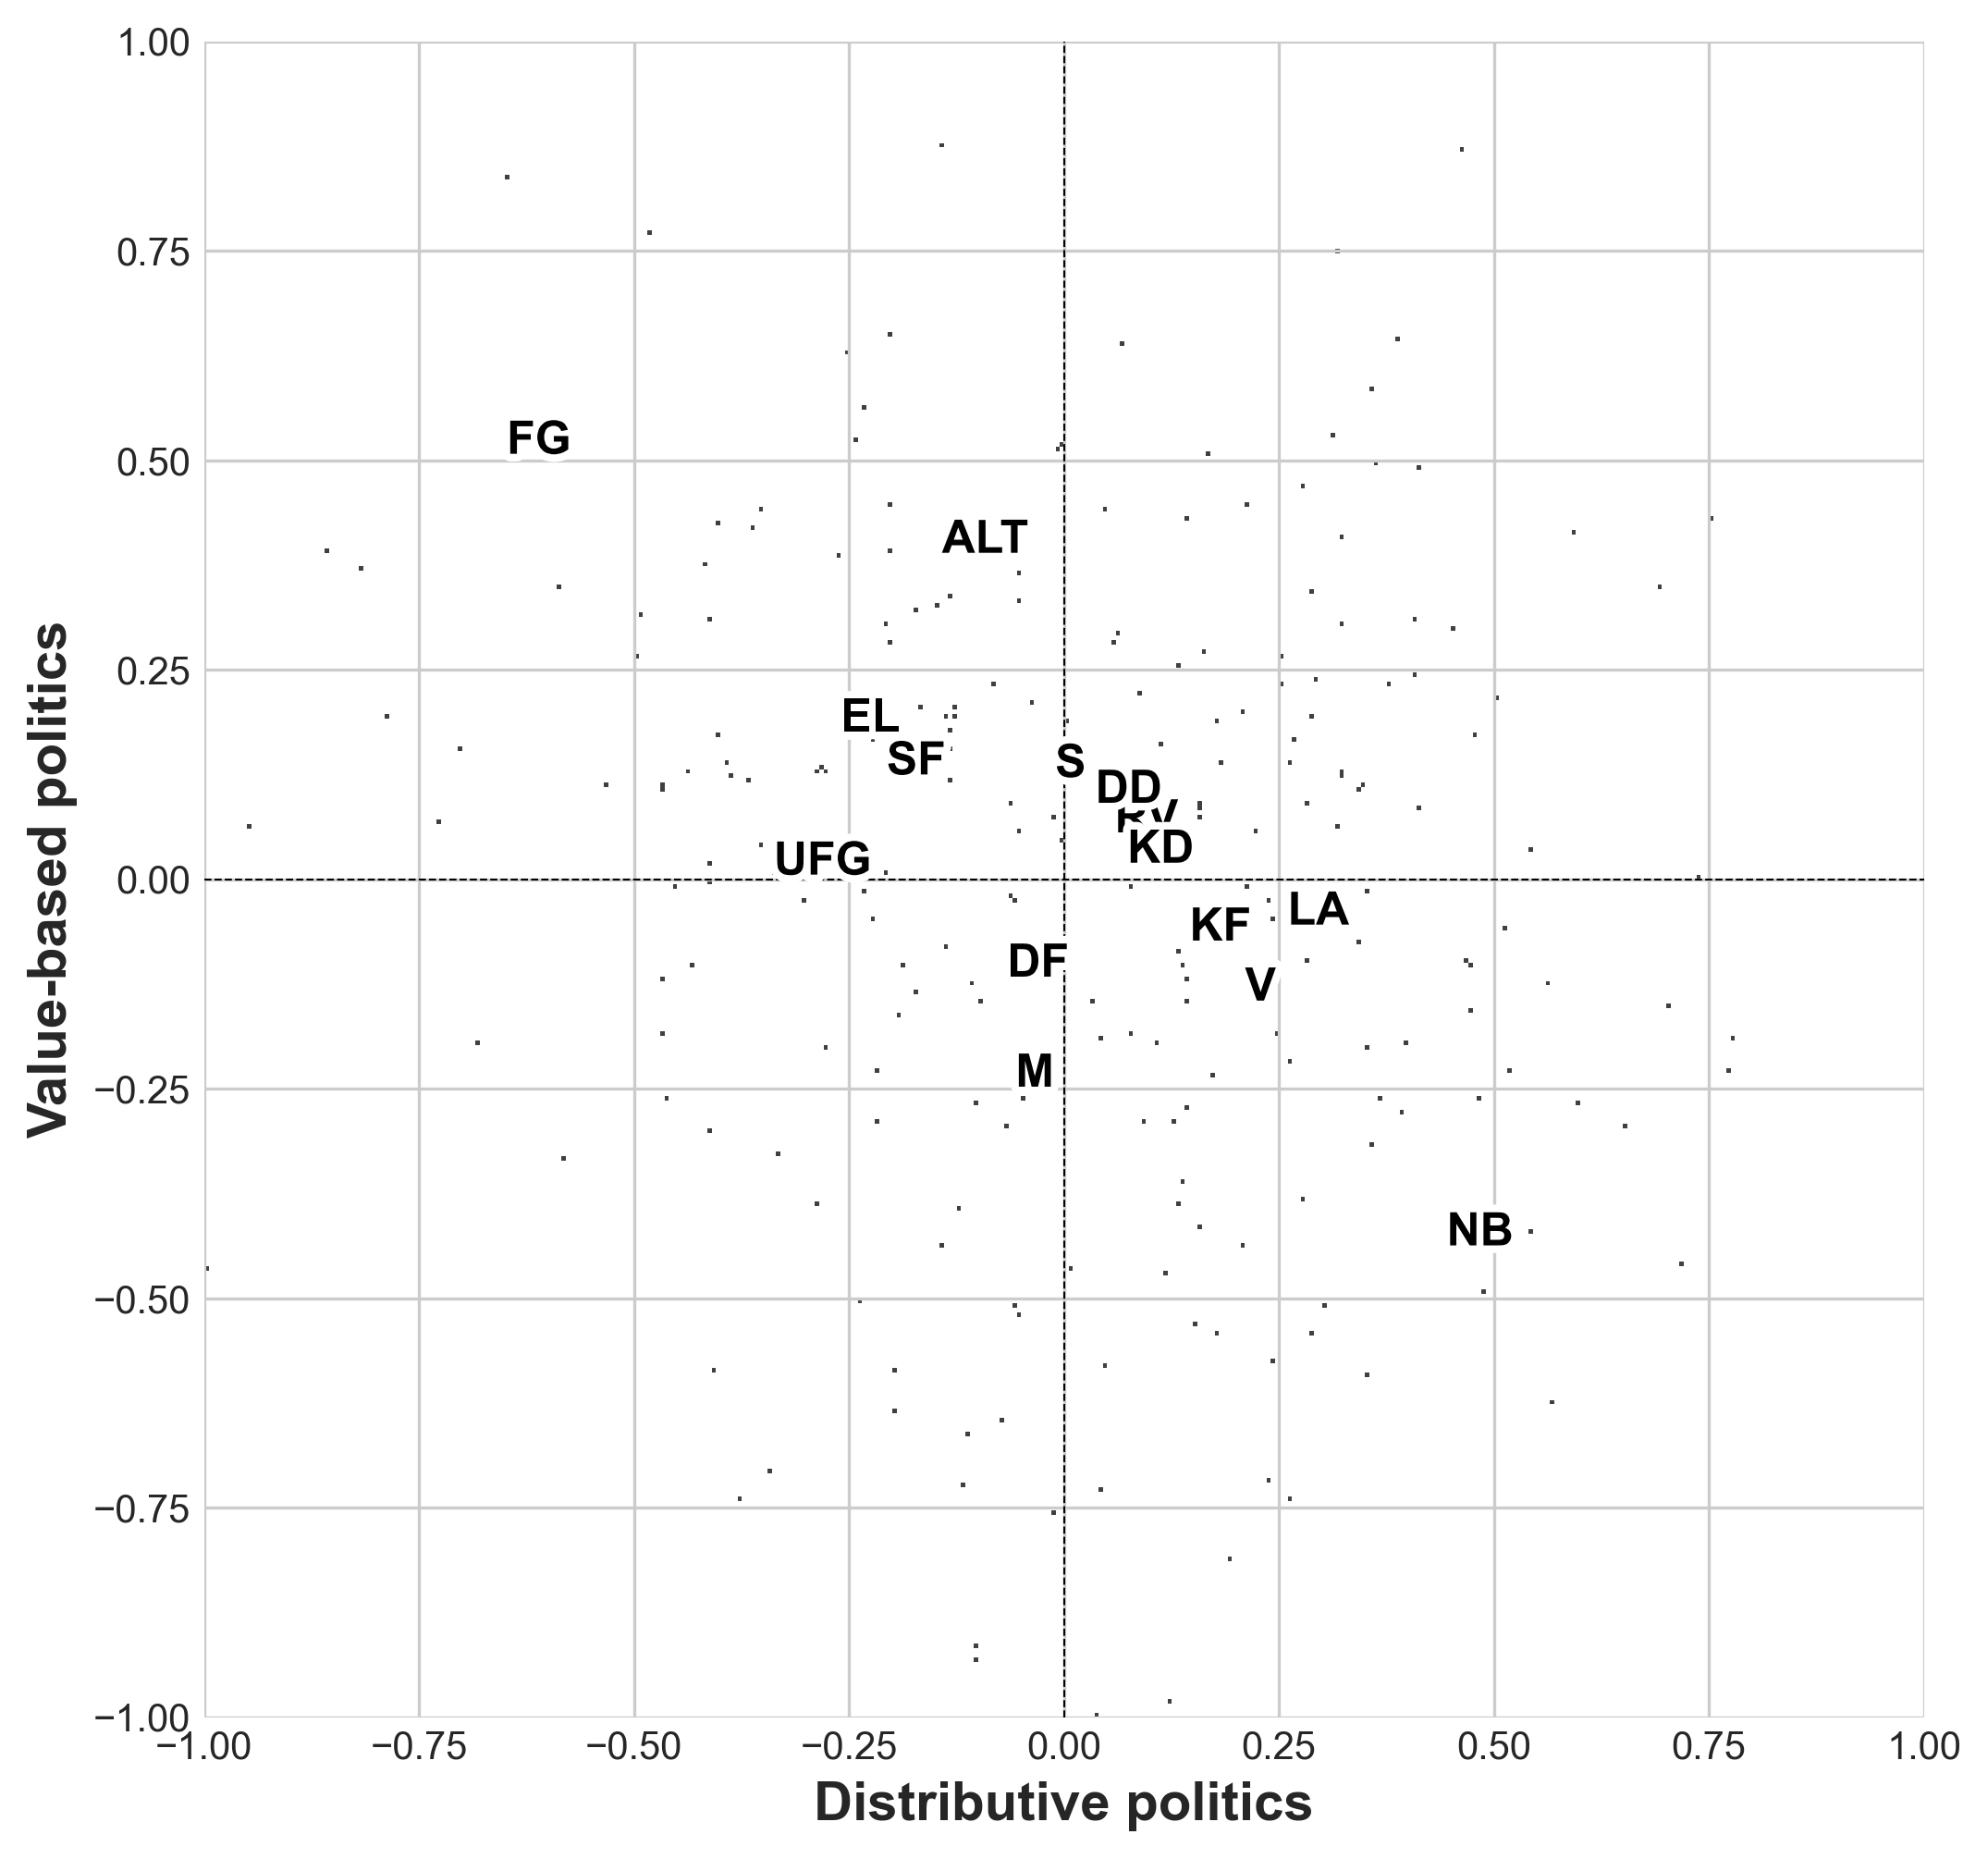

In [88]:
# assume we have a matrix of word and document vectors called `embedding_matrix`
# with shape (num_documents, embedding_dimension)
embedding_matrix = pol2vec_model.document_vectors

# assume we have three subdimension vectors called `v1`, `v2`, and `v3`
# with shape (embedding_dimension,)

# create a matrix called `projection_matrix` with shape (embedding_dimension, 3)
# that has the three subdimension vectors as columns
projection_matrix = np.stack((distrib_axis, value_axis), axis=1)

# project the document vectors onto the subspace described by the three
# subdimension vectors by multiplying the embedding matrix by the projection
# matrix 
# the resulting matrix will have shape (num_documents, 3)
projected_matrix = embedding_matrix.dot(projection_matrix)

# The resulting projected_matrix will be a matrix with shape (num_documents, 3)
# that represents the document vectors projected onto the subspace described by
# the three "special" vectors. Each row of the matrix corresponds to a document,
# and the three columns correspond to the three sub-dimensions of populism
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
#from mpl_toolkits.mplot3d import Axes3D

# Assume you have a matrix of politician embeddings in the populism subspace,
# where each row represents an embedding and each column represents a subdimension.
embeddings = projected_matrix

normalised_emb = 2*(embeddings - np.min(embeddings, axis=0)) / np.ptp(embeddings, axis=0) - 1

# Initialize the plot and set the axis labels
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111) #, projection='3d'
ax.set_xlabel('Distributive politics', size = 14, weight = 'bold')
ax.set_ylabel('Value-based politics', size = 14, weight = 'bold')
#ax.set_zlabel('Moralised politics')

# Create a scatter plot of the politician embeddings
xs = normalised_emb[:,0]
ys = normalised_emb[:,1]
#zs = embeddings[:,2]

ax.scatter(xs, ys, s=50, alpha=0.75, color=combined_hover['color'][:237]) #, zs

# add labels at median of each party
for party in party_labels['party']:
    party_emb = normalised_emb[combined_hover['party'][:237] == party]
    party_xs = party_emb[:,0]
    party_ys = party_emb[:,1]
    ax.text(np.median(party_xs), np.median(party_ys), party, size=12, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=4, foreground='white')])


# add vline to plot
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(y=-0, color='black', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Show the plot
plt.show()